## Metaprogramowanie

Plan:

+ reprezentacja programu jako struktury danych
+ drzewo skladni abstrakcyjnej
+ symbole
+ wyrazenia ich interpolacja i ewaluacja
+ makra
+ makra hygienic 
+ makra uzywane w celu poprawy efektywnosci 
+ funkcje generowane

### Reprezentacja programu

<b>“code is data and data is code“</b>

Kazdy kawalek kodu jest reprezentowany wewnetrznie jako zwykla struktura danych w Julii (nazywana wyrazeniem - expression) 

Homoikoniczność (homoiconics) (grecki: homo="tak samo",  icon="reprezentacja")  to cecha jezykow programowania:
 - kod programu jest struktura danych dostepnych z poziomu jezyka
 - program moze trasformowac, a takze generowac nowy kod.

w Julii rozwiazania dot homoikoniczności sa inspirowane przez jezyk Lisp, gdzie kod i dane to po prostu listy. 


In [1]:
# program w Julii mozna wyciagnac z napisu np.:  
prog = "12 + 30"

"12 + 30"

In [2]:
# możemy dokonać ich rozkładu gramatycznego
ex1 = parse(prog)

:(12 + 30)

In [3]:
typeof(ex1)

Expr

Reprezentacja kodu to typ Expr

```julia
type Expr
 head::Symbol
 args::Array{Any,1}
 typ
end
```

In [4]:
ex1 |> fieldnames

3-element Array{Symbol,1}:
 :head
 :args
 :typ 

In [5]:
# rodzaj wyrażenia
#mozliwe rodzaje wyrazen http://docs.julialang.org/en/stable/devdocs/ast/
ex1.head

:call

In [6]:
# arguementy
ex1.args

3-element Array{Any,1}:
   :+
 12  
 30  

In [7]:
# typ zwracany
ex1.typ

Any

In [8]:
# wyrażenia możemy tworzyć ręcznie
ex2 = Expr(:call, :+, 12, 30)

:(12 + 30)

In [9]:
ex1==ex2

true

In [10]:
# Drzewo składni abstrakcyjnej (AST - abstract syntax tree)
ex3 = parse("2+a*b-c")
dump(ex3)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol -
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Int64 2
        3: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol *
            2: Symbol a
            3: Symbol b
          typ: Any
      typ: Any
    3: Symbol c
  typ: Any


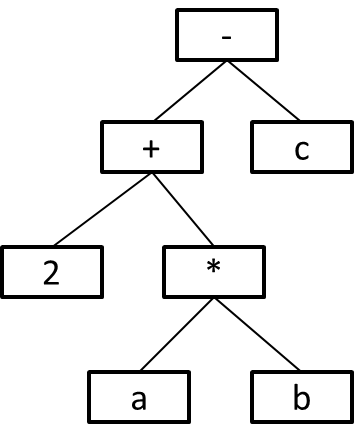

In [11]:
#Drzewo skladni abstrakcyjnej - wizualnie
#wyswietlenie obrazka png wymaga zaistalowania pakietow Pkg.add("Images"); Pkg.add("FileIO")
using Images
using FileIO
img = load("/home/user/drzewo.png")

In [12]:
Meta.show_sexpr(ex3)

(:call, :-, (:call, :+, 2, (:call, :*, :a, :b)), :c)

### Symbole

symbol czyli tzw. "interned string" - Julia przechowuje tylko jedna kopie, ktorej nie mozna zmieniac w trakcie dzialania programu  

In [13]:
:foo

:foo

In [14]:
typeof(:foo)

Symbol

Konstruktor symbol

In [15]:
Symbol("foo")==:foo

true

In [16]:
Symbol(:var,'_',"sym")

:var_sym

### Wyrażenia 

In [17]:
# cytowanie (quote operator)  - traktuj argument jak dane, nie jak kod
ex = :(a+b*c+1)

:(a + b * c + 1)

In [18]:
typeof(ex)

Expr

In [19]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((4,))
    1: Symbol +
    2: Symbol a
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol *
        2: Symbol b
        3: Symbol c
      typ: Any
    4: Int64 1
  typ: Any


In [20]:
# to jest to samo
:(a + b*c + 1)  == 
parse("a + b*c + 1") ==
Expr(:call, :+, :a, Expr(:call, :*, :b, :c), 1)

true

In [21]:
#  reprezentacja blokow jako wyrazen
ex4=:(begin x = 1
        y = 2
        x + y
        end)

quote  # In[21], line 2:
    x = 1 # In[21], line 3:
    y = 2 # In[21], line 4:
    x + y
end

In [22]:
dump(ex4)

Expr
  head: Symbol block
  args: Array{Any}((6,))
    1: Expr
      head: Symbol line
      args: Array{Any}((2,))
        1: Int64 2
        2: Symbol In[21]
      typ: Any
    2: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol x
        2: Int64 1
      typ: Any
    3: Expr
      head: Symbol line
      args: Array{Any}((2,))
        1: Int64 3
        2: Symbol In[21]
      typ: Any
    4: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol y
        2: Int64 2
      typ: Any
    5: Expr
      head: Symbol line
      args: Array{Any}((2,))
        1: Int64 4
        2: Symbol In[21]
      typ: Any
    6: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Symbol x
        3: Symbol y
      typ: Any
  typ: Any


In [23]:
# inny sposob na wyrazenie zawierajace reprezentacje blokow (taki  sam efekt  jak wyzej)
ex = quote 
        x = 1
        y = 2
        x + y
    end

quote  # In[23], line 3:
    x = 1 # In[23], line 4:
    y = 2 # In[23], line 5:
    x + y
end

In [24]:
dump(ex)

Expr
  head: Symbol block
  args: Array{Any}((6,))
    1: Expr
      head: Symbol line
      args: Array{Any}((2,))
        1: Int64 3
        2: Symbol In[23]
      typ: Any
    2: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol x
        2: Int64 1
      typ: Any
    3: Expr
      head: Symbol line
      args: Array{Any}((2,))
        1: Int64 4
        2: Symbol In[23]
      typ: Any
    4: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol y
        2: Int64 2
      typ: Any
    5: Expr
      head: Symbol line
      args: Array{Any}((2,))
        1: Int64 5
        2: Symbol In[23]
      typ: Any
    6: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Symbol x
        3: Symbol y
      typ: Any
  typ: Any


### Interpolacja

In [25]:
# wyrazenie nastepujace po $ jest od razu obliczane 
# moze byc uzyta do wygodnego i czytelnego tworzenia wyrazen 
a = 1;
ex = :($a + b)
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Symbol b
  typ: Any


### Ewaluacja

In [26]:
# funkcja eval() wylicza wartosc wyrazenia
ex = :(1+2)
eval(ex)

3

In [27]:
ex = :(a + b)

:(a + b)

In [28]:
eval(ex)

LoadError: UndefVarError: b not defined

In [29]:
a = 1; b = 2;
eval(ex)

3

In [30]:
# definiujemy wyrazenie nadajace x wartosc 1
ex = :(x = 1)

:(x = 1)

In [31]:
# wyrazenie nie jest jeszcze obliczone
x

LoadError: UndefVarError: x not defined

In [32]:
# kiedy wyrazenie jest obliczone pojawia się efekt uboczny w postaci nadanej wartosci x
eval(ex)

1

In [33]:
x

1

In [34]:
#przyklad:
a=1;b=1
# za "a" jest od razu podstawiane "1", b jest symbolem obliczanym pozniej przy uzyciu funkcji eval 
ex = Expr(:call, :+, a, :b)
a=0;b=2
eval(ex)

3

#### Funkcje na wyrazeniach

In [35]:
#mozemy manipulowac wyrazeniami 
#przyklad funkcji, ktora jako argumenty pobiera wyrazenia i zwraca wyprodukowane wyrazenie
function math_expr(op, op1, op2)
         expr = Expr(:call, op, op1, op2)
         return expr
end
ex=math_expr(:+, 1, Expr(:call, :*, 4, 5))

:(1 + 4 * 5)

In [36]:
eval(ex)

21

In [37]:
# Funkcja, ktora podwaja liczbowe argumenty, nie zmieniajac reszty wyrazenia:
function make_expr2(op, opr1, opr2)
     opr1f, opr2f = map(x -> isa(x, Number) ? 2*x : x, (opr1, opr2))
     retexpr = Expr(:call, op, opr1f, opr2f)
     return retexpr
end

make_expr2 (generic function with 1 method)

In [38]:
make_expr2(:+, 1, 2)

:(2 + 4)

In [39]:
ex = make_expr2(:+, 1, Expr(:call, :*, 5, 8))

:(2 + 5 * 8)

In [40]:
eval(ex)

42

### Makra

Etapy przetwarzania kodu(przypomnienie):
 
 1. zrodla
 2. parsowanie
 3. <b>rozwijanie makr</b>
 4. lowering (@code_lowered) - posrednia reprezentacje kodu  w formie Abstract Syntax Three
 5. type inference - okreslanie typow
 6. inlining - funkcje inline
 7. generated function expansion (@code_typed)
 8. generacja kodu (@code_llvm)
 9. native compilation - do assemblera (@code_native)
 10. RUN
 
  Makra pozwalaja programiscie tworzyc i wstawiac fragmenty kodu przed wykonaniem calosci kodu.        

In [41]:
macro sayhello()
    return :( println("Hello, world!") )
end

@sayhello (macro with 1 method)

kompilator zastapi @sayhello przez  :(println("Hello, world!"))

In [42]:
#makro jest wykonywane przy uzyciu symbolu @
@sayhello

Hello, world!


In [43]:
#makro z parametrami:
macro sayhello(name1, name2)
    return :( println("Hello, ", $name1, " i ", $name2) )
end


@sayhello (macro with 2 methods)

In [44]:
#makroexpand  pokazuje na jakie wyrazenie makro jest rozwijane bez wywolywania eval() na nim
#nastepuje interpolacja name1 i name2
macroexpand(:(@sayhello("Ala", "Ola")))

:(println("Hello, ","Ala"," i ","Ola"))

In [45]:
@sayhello("Ala", "Ola")

Hello, Ala i Ola


In [46]:
@sayhello "Ola" "Ala"

Hello, Ola i Ala


In [47]:
# Nie nalezy mieszac notacji "nawiasowej"  z  notacja "z odstepami", poniewaz
# odstep pomiedzy nazwa makra i argumentami powoduje, ze Julia traktuje argument jako krotke:
@sayhello ("Ala","Ola")

LoadError: MethodError: no method matching @sayhello(::Expr)[0m
Closest candidates are:
  @sayhello(::ANY, [1m[31m::ANY[0m) at In[43]:3
  @sayhello() at In[41]:2[0m

In [48]:
# makro otrzymuje parametry jako symbole, literaly lub wyrazenie
#mozna to badac funkcja  show() 
macro showarg(x)
   show(x)
end

@showarg (macro with 1 method)

In [49]:
# symbol
@showarg(a)

:a

In [50]:
#literal
@showarg(1)

1

In [51]:
# wyrazenie
@showarg(1+2)

:(1 + 2)

In [52]:
#wyrazenie
@showarg (println("hej"))

:(println("hej"))

Makra pozwalaja programiscie tworzyc i wstawiac fragmenty kodu przed wykonaniem calosci. Szczegolowy przyklad:

In [53]:
macro twostep(arg)
    println("I execute at parse time. The argument is: ", arg)

    return :(println("I execute at runtime. The argument is: ", $arg))
end

@twostep (macro with 1 method)

In [54]:
ex = macroexpand( :(@twostep :(1,2,3) ));

I execute at parse time. The argument is: $(Expr(:quote, :((1,2,3))))


In [55]:
typeof(ex)

Expr

In [56]:
ex

# typ copyast - argumentem tego wyrazenia jest drzewo AST  kopiowane rekurencyjnie na etapie wykonania 

# QuoteNode - pomocniczy typ danych w posredniej reprezentacji kodu
# zawiera pole wartosc, w ktorej przechowywuje symbole i wyrazenia, zwraca zawartosc tego pola  bez evaluacji 
# np. dla symbolu :a zwraca po prostu a,  a nie obliczona wartosc a  

:(println("I execute at runtime. The argument is: ",$(Expr(:copyast, :($(QuoteNode(:((1,2,3)))))))))

In [57]:
eval(ex)

I execute at runtime. The argument is: (1,2,3)


In [58]:
@twostep (1,2,3)

I execute at parse time. The argument is: (1,2,3)
I execute at runtime. The argument is: (1,2,3)


In [59]:
# Tutaj nie byloby mozliwe napisanie tego jako funkcji myassert(), 
# poniewaz nie moznaby bylo wypisac zawartosci wyrazenia ex, 
# na etapie wykonania znamy tylko wartosc ex 
# t.j. wiemy,  czy ex jest true/false a nie wiemy ze to powstalo np. z porownania 1==1.0 .

macro myassert(ex)
    return :($ex ? nothing : error("Assertion failed: ", $(string(ex))))
end

@myassert (macro with 1 method)

In [60]:
@myassert 1==1.0

In [61]:
@myassert 1==0

LoadError: Assertion failed: 1 == 0

In [62]:
macroexpand(:(@myassert(1==1)))

:(if 1 == 1
        nothing
    else 
        error("Assertion failed: ","1 == 1")
    end)

In [63]:
# tutaj bardziej zaawansowane przetwarzanie argumentow makra w fazie parsowania zanim wyprodukujemy wyrazenie
# dla fazy wykonania
macro assert(ex, msgs...)
    msg_body = isempty(msgs) ? ex : msgs[1]
    msg = string(msg_body)
    return :($ex ? nothing : throw(AssertionError($msg)))
end


@assert (macro with 1 method)

In [64]:
macroexpand(:(@assert a==b))

:(if a == b
        nothing
    else 
        throw(AssertionError("a == b"))
    end)

In [65]:
macroexpand(:(@assert a==b "a should equal b!"))

:(if a == b
        nothing
    else 
        throw(AssertionError("a should equal b!"))
    end)

### Hygienic macros
Makra "hygienic" musza upewnic sie, ze zmienne, ktore wprowadzaja i zwracane wartosci nie "kloca sie" z istniejacymi zmiennymi w kodzie do ktorego sie rozwina.

Ilustracja:

In [66]:
macro time2(ex)
  return quote
    local t0 = time()
    local val = $ex
    local t1 = time()
    println("elapsed time: ", t1-t0, " seconds")
    val
  end
end

@time2 (macro with 1 method)

Chcemy
-  t0, t1, val - prywatne tymczasowe zmienne
-  time(), println() standardowe funkcje, uzytkownik moze miec zdefioniowana zmienna time

Co jesli wyrazenie uzytkownika <i>ex</i> np. zawiera podstawienie do zmiennych t0 lub t1 ? 
Co jesli uzytkownik ma zdefioniowana zmienna time ?


Julia rozwiazuje czesc problemow w ten sposob:

zmienna jest klasyfikowana jako local:
 - jesli nastepuje przypisywanie do zmiennej i nie jest ona zadeklarowana jako globalna
 - lub jesli jest wprost zadeklarowana jako local
 - lub jesli jest uzyta jako argument funkcji

jesli zmienna jest lokalna <b>nastepuje zmiana jej nazwy</b> na unikalna poprzez uzycie gensym()



In [67]:
macro zerox1()
  return :(x=0)
end
macroexpand(:(@zerox1))

:(#4#x = 0)

In [68]:
function foo()
  x = 1
  @zerox1
  x  
end

foo (generic function with 1 method)

In [69]:
foo()

1

Funkcja esc(ex) - wyrazenie ex nie jest rozwijane w trakcie rozwijania makra, tylko jest wklejane do wyniku "tak jak jest". 

W ten sposob mozemy kontrolowac, ktore zmienne maja wplywac na zmienne uzytkownika makra, a ktore nie.

In [70]:
macro zerox2()
  return esc(:(x=0))
end

function foo2()
  x = 1
  @zerox2
  x  # is zero
end

foo2 (generic function with 1 method)

In [71]:
foo2()

0

In [72]:
macroexpand(:(@zerox2))

:(x = 0)

In [73]:
#przyklad makro timeit
macro timeit(ex)
  return quote
    local t0 = time()
    local val = $(esc(ex))
    local t1 = time()
    println("elapsed time: ", t1-t0, " seconds")
    val
  end
end
@timeit factorial(10)
macroexpand(:(@timeit factorial(10)))

elapsed time: 0.0056269168853759766 seconds


quote  # In[73], line 4:
    local #9#t0 = time() # In[73], line 5:
    local #10#val = factorial(10) # In[73], line 6:
    local #11#t1 = time() # In[73], line 7:
    println("elapsed time: ",#11#t1 - #9#t0," seconds") # In[73], line 8:
    #10#val
end

Uwaga: w dokumentacji Julia powinna radzic sobie ze zmiennymi globalnymi biorac je ze srodowiska definicji makra
Niestety robi to tylko, jesli uzyjemy mechanizmu modulow.
Jest to bug dot makr higienic
https://github.com/JuliaLang/julia/issues/14893

In [74]:
#bledne dzialanie (bug)
macro g(y)
    :((x, $y, $(esc(y))))
end

x = 1
function t()
    x = 2
    println(macroexpand(:(@g(x))))
    println(@g(x))
end

t()
println(x)

(x,x,x)
(2,2,2)
1


In [75]:
# poprawne dzialanie
module A
macro g(y)
    :((x, $y, $(esc(y))))
end
x = 1
end

x = 3

function t1()
    x = 2
    println(macroexpand(:(A.@g(x))))
    println(A.@g(x))
end

t1()
println(x)

(A.x,A.x,x)
(1,1,2)
3


#### Uzycie makr do przyspieszania obliczen - przyklad z algorytmem Hornera

Sluzy do obliczania wartosci wielomianow $a_nx^n+a_{n-1}x^{n-1}+ ... +a_0$ 

$ b_n=a_n $

$ b_{n-1}=a_{n-1}+b_nx$

$ b_{n-2}=a_{n-2}+b_{n-1}x$

....

$b_{0}=a_{0}+b_{1}x$

In [76]:
function poly_horner(x, a...)
    b=zero(x)
    for i= length(a):-1:1
        b= a[i] + b * x
    end
    return b
end

poly_horner (generic function with 1 method)

In [77]:
f_horner(x)=poly_horner(x,1,2,3,4,5)

f_horner (generic function with 1 method)

In [78]:
f_horner(1)
using BenchmarkTools
@benchmark f_horner(3.5)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     29.496 ns (0.00% GC)
  median time:      30.618 ns (0.00% GC)
  mean time:        33.400 ns (3.58% GC)
  maximum time:     2.065 μs (97.23% GC)
  --------------
  samples:          10000
  evals/sample:     994
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [79]:
macro horner(x, p...)
    ex= esc(p[end])
    for i = length(p)-1:-1:1
         ex= :(muladd(t, $ex, $(esc(p[i]))))
    end
    Expr(:block, :(t=$(esc(x))), ex)
end

@horner (macro with 1 method)

In [80]:
macroexpand(:(@horner(3.5,1,2,3,4,5)))

quote 
    #241#t = 3.5
    muladd(#241#t,muladd(#241#t,muladd(#241#t,muladd(#241#t,5,4),3),2),1)
end

In [81]:
f_horner_macro(x)=@horner(x, 1,2,3,4,5)

f_horner_macro (generic function with 1 method)

In [82]:
f_horner_macro(1)

15

In [83]:
@benchmark f_horner_macro(3.5)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.662 ns (0.00% GC)
  median time:      1.720 ns (0.00% GC)
  mean time:        1.783 ns (0.00% GC)
  maximum time:     29.544 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000
  time tolerance:   5.00%
  memory tolerance: 1.00%

### Generacja kodu

In [84]:
# funkcja eval moze sluzyc do wygodnej generacji kodu, 
#ten kod generuje w petli wersje 3 argumentowe dla operatorow dwuargumentowych 
import Base.+
import Base.*
import Base.&
import Base.|
import Base.$
for op = (:+, :*, :&, :|, :$)
  eval(quote 
    ($op)(a,b,c) =  ($op)(($op)(a,b),c)
  end)
end


In [85]:
#to mozna napisac prosciej tak
for op = (:+, :*, :&, :|, :$)
  eval(:(($op)(a,b,c) = ($op)(($op)(a,b),c)))
end

In [86]:
# albo dalej uproscic uzywajac makra @eval
for op = (:+, :*, :&, :|, :$)
  @eval ($op)(a,b,c) = ($op)(($op)(a,b),c)
end

### Generated functions

Funkcja  rozwija sie  w <b>momencie kompilacji</b> kiedy znane sa typy argumentow.

Funkcje generowane sa rozwijane na pozniejszym etapie niz makra (na etapie rozwijania makr nie sa znane typy argumentow)

W ciele funkcji generowanych dzialamy na typach argumentow
 
Generalna zasada: funkcja jest generowana <b> raz na kazde wywolanie z innym typem</b>, na etapie kompilacji, a nie wykonania 

Funcje generowane sa uzywane do przeniesienia czesci dzialan z etapu wykonania  na etap kompilacji, wtedy te dzialania wykonywane sa raz na typ, a nie przy kazdym uruchomieniu.

Przykladem uzycia jest technika <b> loop-unrolling </b>- usuwanie petli i zamienianie je wyrazeniami

UWAGA: Funkcja moze byc generowana wiecej razy niz liczba wywolan z roznymi typami - nie jest to zabronione, jest to kwestia implementacji Julii, dlatego nie nalezy wprowadzac efektow ubocznych do jej dzialania 


In [87]:
# mnozenym wymiary tablicy np dla tablicy o wymiarach 10x5x5 wyjdzie 250
function prod_dim{T, N}(x::Array{T,N})
     s=1
    for i = 1:N
        s= s* size(x,i)
    end
    return s
end

prod_dim (generic function with 1 method)

In [88]:
A1=rand(10,5,5)

10×5×5 Array{Float64,3}:
[:, :, 1] =
 0.498674  0.366678  0.70634   0.0917911  0.251301
 0.758486  0.608502  0.828472  0.12586    0.392426
 0.408533  0.284468  0.536478  0.252608   0.276671
 0.827966  0.250599  0.199775  0.46077    0.767781
 0.898436  0.171314  0.271707  0.34488    0.788187
 0.825358  0.612386  0.253353  0.943004   0.831145
 0.521736  0.839714  0.329378  0.791577   0.735238
 0.770981  0.92662   0.390179  0.217324   0.450329
 0.44564   0.466917  0.347214  0.278655   0.454796
 0.455781  0.24763   0.60404   0.590953   0.769947

[:, :, 2] =
 0.0772007  0.712693  0.804545   0.291472   0.669629 
 0.755343   0.791166  0.729609   0.343929   0.957457 
 0.406871   0.613459  0.927818   0.79755    0.658058 
 0.516785   0.386104  0.804158   0.150702   0.153677 
 0.618345   0.358165  0.0601231  0.188762   0.563219 
 0.032639   0.672303  0.91762    0.35147    0.331243 
 0.219929   0.357514  0.107508   0.956219   0.166644 
 0.712933   0.413519  0.29303    0.545689   0.658218 
 0.50522

In [89]:
prod_dim(A1)

250

In [90]:
@generated function prod_dim_gen{T, N}(x::Array{T,N})
    ex= :(1)
    for i= 1:N
        ex= :(size(x, $i)*$ex)
    end
    return ex
end

prod_dim_gen (generic function with 1 method)

In [91]:
prod_dim_gen(A1)

250

In [92]:
function prod_dim_gen_impl{T, N}(x::Array{T,N})
    ex= :(1)
    for i= 1:N
        ex= :(size(x, $i)*$ex)
    end
    return ex
end

prod_dim_gen_impl (generic function with 1 method)

In [93]:
prod_dim_gen_impl(A1)

:(size(x,3) * (size(x,2) * (size(x,1) * 1)))

#### Przyklad z wyliczaniem indeksu

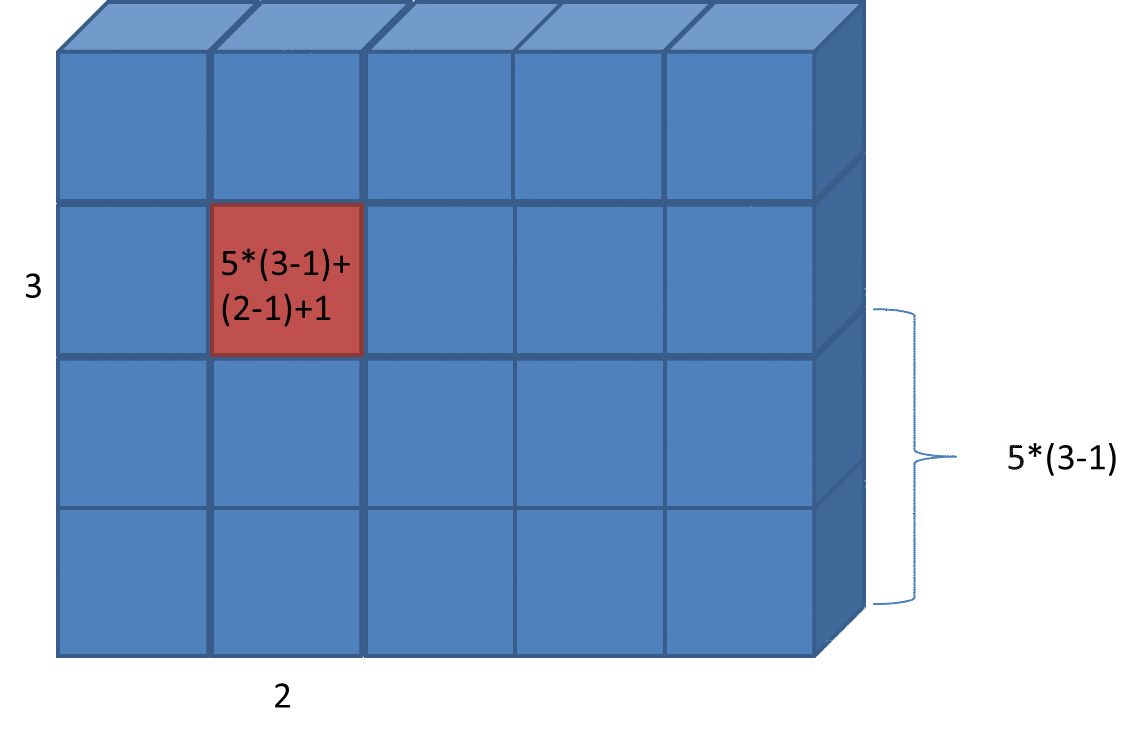

In [94]:
# chodzi o wyliczenie liniowego indeksu w kostce wielowymiarowej
# rysunek dla dwu wymiarow:
using Images
using FileIO
img = load("/home/user/kostka.png")

In [95]:

function sub2ind_loop{N}(dims::NTuple{N}, I::Integer...)
    # N - rozmiar tablicy
    ind = I[N] - 1

    for i = N-1:-1:1
       print(I[i]-1, " + ", dims[i], " * ", ind)
        ind = I[i]-1 + dims[i]*ind
        println(" = ", ind)
    end
    println(ind)
    return ind + 1
end


sub2ind_loop (generic function with 1 method)

In [96]:
sub2ind_loop((5,4), 2,3)

1 + 5 * 2 = 11
11


12

In [97]:
sub2ind_loop((5,4,3), 2,3,2)

2 + 4 * 1 = 6
1 + 5 * 6 = 31
31


32

In [98]:
# przez uzycie funkcji generowanej mozemy wykonac petle juz na etapie kompilacji rozwijajac ja w wyrazenie
# poniewaz wszyskie informacje, ktore potrzebujemy (ilosc wywolan petli) sa zapisane w typie argumentow NTuple{N}


@generated function sub2ind_gen{N}(dims::NTuple{N}, I::Integer...)
    ex = :(I[$N] - 1)
    for i = N-1:-1:1
        ex = :(I[$i] - 1 + dims[$i]*$ex)
    end
    return :($ex + 1)
end

sub2ind_gen (generic function with 1 method)

In [99]:
# zeby podgladnac, do czego powyzsza funkcja sie wygeneruje, tworzymy zwykla funkcje z takim samym cialem  i wywolujemy

function sub2ind_gen_impl{N}(dims::Type{NTuple{N}}, I...)
           ex = :(I[$N] - 1)
           for i = N-1:-1:1
               ex = :(I[$i] - 1 + dims[$i]*$ex)
           end
           return :($ex + 1)
end

sub2ind_gen_impl (generic function with 1 method)

In [100]:
#widac, ze petla zniknela, mamy ostateczne wyrazenie z odwolaniami do elementow tablic.
sub2ind_gen_impl(Tuple{Int,Int}, Int, Int)

:(((I[1] - 1) + dims[1] * (I[2] - 1)) + 1)